In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-54c34cfa-21c8-1ab2-a277-4846d25f4cd1)


# Config

In [ ]:
CROP_SIZE = 512
IMG_SIZE = 512
STAGE = 2
DATA_DIR = '/content/drive/My Drive/BMIproject/dataset'
TRAIN_DIR = '/content/drive/My Drive/BMIproject/dataset/train'
TEST_DIR = '/content/drive/My Drive/BMIproject/dataset/test'

# Dataset

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 17.4MB/s 


In [ ]:
%cd /content/drive/My\ Drive/BMIproject/

/content/drive/My Drive/BMIproject


In [ ]:
!ls

 1.jpg				        model2.pt
 2.jpg				        model3.pt
 3.jpg				        my.jpg
 4.jpg				        my.png
 BMIproject.ipynb		        output
 dataset			        pytorch_retinanet
'GCP Credits Request Link - RSNA.txt'   src
 main.ipynb			        stage_2_sample_submission.csv
 model0.pt			        temp
 model1.pt


In [ ]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import sys
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from typing import List, Set, Dict, Tuple, Optional
import math
import time
import random
from contextlib import contextmanager
import skimage.io
import skimage.transform
from imgaug import augmenters as iaa
from skimage.transform import SimilarityTransform, AffineTransform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.auto import tqdm, trange
import pydicom
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from io import BytesIO  
from io import StringIO
import scipy.misc
import tensorflow as tf

from torch import nn, optim

## Stratified K-Folds cross-validator

In [ ]:
# def create_folds(df: pd.DataFrame, X: pd.DataFrame, y: pd.DataFrame, nb_folds: int, if_save: bool) -> pd.DataFrame:
#     df["fold"] = -1 
#     skf = StratifiedKFold(n_splits=nb_folds, shuffle=True, random_state=42)
#     for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
#         df.loc[test_index, "fold"] = fold
#     if if_save:
#         df.to_csv(os.path.join(DATA_DIR, "folds.csv"), index=False)
#     return df


# nb_folds = 4
# training_samples = pd.read_csv(os.path.join(DATA_DIR, f"stage_{str(STAGE)}_detailed_class_info.csv"))
# training_samples = training_samples.drop_duplicates().reset_index(drop=True)
# X = training_samples["patientId"]
# y = training_samples["class"]


# folds = create_folds(training_samples, X, y, nb_folds, if_save= True)


## Augmentation

In [ ]:
class TransformCfg:
    """
    Configuration structure for crop parameters
    and augmentations
    """

    def __init__(self, crop_size: int, src_center_x: int, src_center_y: int, scale_x: float=1.0, scale_y: float=1.0, angle: float=0.0, shear: float=0.0, hflip: bool=False, vflip: bool=False):
        self.crop_size = crop_size
        self.src_center_x = src_center_x
        self.src_center_y = src_center_y
        self.angle = angle
        self.shear = shear
        self.scale_y = scale_y
        self.scale_x = scale_x
        self.vflip = vflip
        self.hflip = hflip

    def __str__(self) -> str:
        return str(self.__dict__)

    def transform(self) -> AffineTransform:
        scale_x = self.scale_x
        if self.hflip:
            scale_x *= -1
        scale_y = self.scale_y
        if self.vflip:
            scale_y *= -1

        tform = skimage.transform.AffineTransform(translation=(self.src_center_x, self.src_center_y))
        tform = skimage.transform.AffineTransform(scale=(1.0 / self.scale_x, 1.0 / self.scale_y)) + tform
        tform = skimage.transform.AffineTransform(rotation=self.angle * math.pi / 180, shear=self.shear * math.pi / 180) + tform
        tform = skimage.transform.AffineTransform(translation=(-self.crop_size / 2, -self.crop_size / 2)) + tform

        return tform

    def transform_image(self, img: np.array) -> np.array:
        crop = skimage.transform.warp(img, self.transform(), mode="constant", cval=0, order=1, output_shape=(self.crop_size, self.crop_size))
        return crop

## Detection Dataset

In [ ]:
class DetectionDataset(Dataset):

    def __init__(self, fold: int, is_training: bool, img_size: int, augmentation_level= 20, crop_source=1024):
        super(DetectionDataset, self).__init__() 
        self.fold = fold
        self.is_training = is_training
        self.img_size = img_size
        self.crop_source = crop_source
        self.augmentation_level = augmentation_level
        self.categories = ["No Lung Opacity / Not Normal", "Normal", "Lung Opacity"]
        samples = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
        samples = samples.merge(pd.read_csv(os.path.join(DATA_DIR, "folds.csv")), on="patientId", how="left")
        samples = samples[samples['class'] == "Lung Opacity"]
        if is_training:
            self.samples = samples[samples.fold != fold]
        else:
            self.samples = samples[samples.fold == fold]
        
        print(len(self.samples))

        self.patient_ids = list(sorted(self.samples.patientId.unique()))
        self.patient_categories = {}
        self.annotations = defaultdict(list)


        # add annotation points for rotation

        for _, row in self.samples.iterrows():
            patient_id = row["patientId"]
            self.patient_categories[patient_id] = self.categories.index(row["class"])
            if row["Target"] > 0:
                x, y, w, h = row.x, row.y, row.width, row.height
                points = np.array(
                    [
                        [x, y + h / 3],
                        [x, y + h * 2 / 3],
                        [x + w, y + h / 3],
                        [x + w, y + h * 2 / 3],
                        [x + w / 3, y],
                        [x + w * 2 / 3, y],
                        [x + w / 3, y + h],
                        [x + w * 2 / 3, y + h],
                    ]
                )
                self.annotations[patient_id].append(points)

    def get_image(self, patient_id):
        """Load a dicom image to an array"""
        try:
            dcm_data = pydicom.read_file(os.path.join(TRAIN_DIR, f"{patient_id}.dcm"))
            img = dcm_data.pixel_array
            return img
        except:
            pass

    def num_classes(self):
        return 3

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        img = self.get_image(patient_id)    
        if self.crop_source != 1024:
            img_source_w = self.crop_source
            img_source_h = self.crop_source
        else:
            img_source_h, img_source_w = img.shape[:2]
        img_h, img_w = img.shape[:2]
  
        # set augmentation levels
        augmentation_sigma = {
            1: dict(scale=0, angle=0, shear=0, gamma=0, hflip=False),
            10: dict(scale=0.1, angle=5.0, shear=2.5, gamma=0.2, hflip=False),
            11: dict(scale=0.1, angle=0.0, shear=2.5, gamma=0.2, hflip=False),
            15: dict(scale=0.15, angle=6.0, shear=4.0, gamma=0.2, hflip=np.random.choice([True, False])),
            20: dict(scale=0.15, angle=6.0, shear=4.0, gamma=0.25, hflip=np.random.choice([True, False])),
            21: dict(scale=0.15, angle=0.0, shear=4.0, gamma=0.25, hflip=np.random.choice([True, False])),
        }[self.augmentation_level]
        # training mode augments
        if self.is_training:
            cfg = TransformCfg(
                crop_size=self.img_size,
                src_center_x=img_w / 2 + np.random.uniform(-32, 32),
                src_center_y=img_h / 2 + np.random.uniform(-32, 32),
                scale_x=self.img_size / img_source_w * (2 ** np.random.normal(0, augmentation_sigma["scale"])),
                scale_y=self.img_size / img_source_h * (2 ** np.random.normal(0, augmentation_sigma["scale"])),
                angle=np.random.normal(0, augmentation_sigma["angle"]),
                shear=np.random.normal(0, augmentation_sigma["shear"]),
                hflip=augmentation_sigma["hflip"],
                vflip=False,
            )
        # validation mode augments
        else:
            cfg = TransformCfg(
                crop_size=self.img_size,
                src_center_x=img_w / 2,
                src_center_y=img_h / 2,
                scale_x=self.img_size / img_source_w,
                scale_y=self.img_size / img_source_h,
                angle=0,
                shear=0,
                hflip=False,
                vflip=False,
            )
        # add more augs in training modes
        crop = cfg.transform_image(img)
        if self.is_training:
            crop = np.power(crop, 2.0 ** np.random.normal(0, augmentation_sigma["gamma"]))
            if self.augmentation_level == 20 or self.augmentation_level == 21:
                aug = iaa.Sequential(
                    [
                        iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
                        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
                        iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),
                    ]
                )
                crop = (
                    aug.augment_image(np.clip(np.stack([crop, crop, crop], axis=2) * 255, 0, 255).astype(np.uint8))[:, :, 0].astype(np.float32)
                    / 255.0
                )
        # add annotation points
        annotations = []
        for annotation in self.annotations[patient_id]:
            points = cfg.transform().inverse(annotation)
            res = np.zeros((1, 4))
            p0 = np.min(points, axis=0)
            p1 = np.max(points, axis=0)
            res[0, 0:2] = p0
            res[0, 2:4] = p1
            annotations.append(res)
        
        target = {}
        
        if len(annotations):
            annotations = np.row_stack(annotations)
        else:
            annotations = np.zeros((0, 4))

        target["boxes"] = annotations
        target["labels"] = [1] * len(annotations)
        return crop, target
                # sample = {"img": crop, "annot": annotations, "scale": 1.0, "category": self.patient_categories[patient_id]}


In [ ]:
import torchvision
from torchvision.models.detection.retinanet import RetinaNetHead

def define_model():
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained= True, pretrained_backbone= True)
    
    num_classes = 2  # 1 class  + background

    model.head = RetinaNetHead(in_channels=256, num_anchors=9, num_classes=2)


    # ### input is grayscale with one channel
    model.backbone.body.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


    model.transform = torchvision.models.detection.transform.GeneralizedRCNNTransform(min_size=(800,), max_size=1333, image_mean=[0.485], image_std= [0.229])
    return model



batch_size = 6



In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def train(fold):

    model = define_model()
    model = model.to(device)
    dataset_train = DetectionDataset(
        fold=fold,
        img_size= IMG_SIZE,
        is_training=True,

    )

    dataset_valid = DetectionDataset(
        fold=fold, img_size= IMG_SIZE, is_training=False
    )
    dataloader_train = DataLoader(
        dataset_train,
        batch_size= 6,
        shuffle=True,
        collate_fn=collate_fn,
        drop_last=True,
    )

    dataloader_valid = DataLoader(
        dataset_valid,
        batch_size=4,
        shuffle=False,
        collate_fn=collate_fn,
        drop_last=True,
    )
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=4, verbose=True, factor=0.2
    )
    model.train()
    cls_loss_train  = []
    reg_loss_train = []
    cls_loss_val  = []
    reg_loss_val = []

    for epoch_num in range(epochs):

        cls_loss_train_tmp  = []
        reg_loss_train_tmp = []
        cls_loss_val_tmp  = []
        reg_loss_val_tmp = []

        for  (images, targets) in tqdm(dataloader_train, desc='Training epoch ' + str(epoch_num+1)):
            images = list(torch.FloatTensor(image).unsqueeze(0).to(device) for image in images)
            for t in targets:
                for k,v in t.items():
                    if k =='boxes':
                        t[k] = torch.FloatTensor(v).to(device)
                    else:
                        t[k] = torch.LongTensor(v).to(device)
            
            out = model (images, targets)
            cls = out['classification']
            reg = out['bbox_regression']

            cls_loss_train_tmp.append(cls.item())
            reg_loss_train_tmp.append(reg.item())
            losses = reg + cls
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            del cls
            del reg


        # with torch.no_grad():
        #     for  (images, targets) in tqdm(dataloader_valid, desc='validation ' + str(epoch_num+1)):
        #         images = list(torch.FloatTensor(image).unsqueeze(0).to(device) for image in images)
        #         for t in targets:
        #             for k,v in t.items():
        #                 if k =='boxes':
        #                     t[k] = torch.FloatTensor(v).to(device)
        #                 else:
        #                     t[k] = torch.LongTensor(v).to(device)         
        #         out = model (images, targets)
        #         cls = out['classification']
        #         reg = out['bbox_regression']
        #         cls_loss_val_tmp.append(cls.item())
        #         reg_loss_val_tmp.append(reg.item())
        #         del cls
        #         del reg
                
        cls_loss_train.append(np.mean(cls_loss_train_tmp))
        reg_loss_train.append(np.mean(reg_loss_train_tmp))
        # cls_loss_val.append(np.mean(cls_loss_val_tmp))
        # reg_loss_val.append(np.mean(reg_loss_val_tmp))

        if scheduler is not None:
            scheduler.step(np.mean(reg_loss_val_tmp))

        
    return cls_loss_train, reg_loss_train, cls_loss_val, reg_loss_val, model




In [16]:
epochs = 20
cls_loss_train, reg_loss_train, cls_loss_val, reg_loss_val, model = train(3)

7176
2379



Epoch     5: reducing learning rate of group 0 to 2.0000e-06.



Epoch    10: reducing learning rate of group 0 to 4.0000e-07.



Epoch    15: reducing learning rate of group 0 to 8.0000e-08.



Epoch    20: reducing learning rate of group 0 to 1.6000e-08.


In [17]:
model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

In [21]:
torch.save(model, 'model'+str(3)+".pt")

# Evaluate

In [22]:
def iou(box1: List[int], box2: List[int]) -> float:
    """
    Helper, calculates Intersection over union
    Args: 
        box1, box2: x, y, w, h of the boxes
    Output:   
        Intersection over union  
    """
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    if w1 * h1 <= 0 or w2 * h2 <= 0:
        return 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])

    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2 - xi1) * (yi2 - yi1)
        union = area1 + area2 - intersect
        return intersect / union

In [23]:
def map_iou(boxes_true: np.ndarray, boxes_pred: np.ndarray, scores: np.ndarray, thresholds: Tuple[float]=(0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75)) -> Optional[float]:
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    Args:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image.
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image.
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate the mean average precision on
    Output:
        map: mean average precision of the image
    """

    # images with no ground truth bboxes are not included in the map score unless
    # there is a false positive detection
    # return None if both are empty, don't count the image in final evaluation
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return 0
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    map_total = 0.0
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1  # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1  # bt has no match, count as FN

        fp = len(boxes_pred) - len(matched_bt)  # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    return map_total / len(thresholds)

In [24]:
def check_metric(fold, model):
    model = model.to(device)
    dataset_train = DetectionDataset(
        fold=fold,
        img_size= IMG_SIZE,
        is_training=True,

    )

    dataset_valid = DetectionDataset(
        fold=fold, img_size= IMG_SIZE, is_training=False
    )
    dataloader_train = DataLoader(
        dataset_train,
        batch_size= 1,
        shuffle=False,
        collate_fn=collate_fn,
        drop_last=True,
    )

    dataloader_valid = DataLoader(
        dataset_valid,
        batch_size= 1,
        shuffle=False,
        collate_fn=collate_fn,
        drop_last=True,
    )

    model.eval()

    map_train = []
    map_val = []

    for i in range(1):

        with torch.no_grad():
            for iter_num, (images, targets) in enumerate(dataloader_train):
                images = list(torch.FloatTensor(image).unsqueeze(0).to(device) for image in images)
                outputs = model(images)
                gt = targets[0]['boxes']
                scores = outputs[0]['scores'].detach().cpu().numpy()
                bboxes = outputs[0]['boxes'].detach().cpu().numpy()
                metric = map_iou(gt, bboxes, scores)
                map_train.append(metric)




        with torch.no_grad():
            for iter_num, (images, targets) in enumerate(dataloader_valid):
                images = list(torch.FloatTensor(image).unsqueeze(0).to(device) for image in images)
                outputs = model(images)
                gt = targets[0]['boxes']
                scores = outputs[0]['scores'].detach().cpu().numpy()
                bboxes = outputs[0]['boxes'].detach().cpu().numpy()
                metric = map_iou(gt, bboxes, scores)
                map_val.append(metric)


        
    return np.mean(map_train), np.mean(map_val)





In [28]:
map_train, map_val = check_metric(3, model)

7176
2379


In [29]:
map_train

0.03469254114207704

In [30]:
map_val

0.035610662797410826

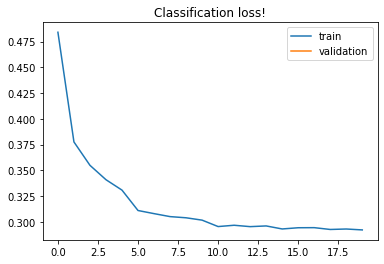

In [18]:

import matplotlib.pyplot as plt 
  

plt.plot(cls_loss_train, label = "train")  
plt.plot(cls_loss_val, label = "validation") 

plt.title('Classification loss!') 

plt.legend() 
  

plt.show() 


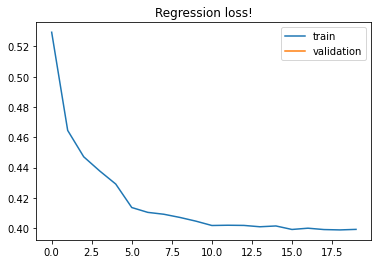

In [19]:

import matplotlib.pyplot as plt 
  

plt.plot(reg_loss_train, label = "train")  
plt.plot(reg_loss_val, label = "validation") 

plt.title('Regression loss!') 

plt.legend() 
  

plt.show() 


In [20]:
print('classification loss train: ' ,np.mean(cls_loss_train))
print('classification loss validation: ' ,np.mean(cls_loss_val))
print('Regression loss train: ' , np.mean(reg_loss_train))
print('Regression loss validation: ' ,np.mean(reg_loss_val))

classification loss train:  0.31795823942626844
classification loss validation:  nan
Regression loss train:  0.41790351470642184
Regression loss validation:  nan


In [ ]:
model = torch.load('model1.pt')

In [ ]:
model = model.to(device)
dataset_train = DetectionDataset(
        fold= 1,
        img_size= IMG_SIZE,
        is_training=True,

    )


dataloader_train = DataLoader(
        dataset_train,
        batch_size= 1,
        shuffle=True,
        collate_fn=collate_fn,
        drop_last=True,
    )

model.eval()




with torch.no_grad():
    for iter_num, (images, targets) in enumerate(dataloader_train):
        images = list(torch.FloatTensor(image).unsqueeze(0).to(device) for image in images)
        outputs = model(images)
        gt = targets[0]['boxes']
        scores = outputs[0]['scores'].detach().cpu().numpy()
        bboxes = outputs[0]['boxes'].detach().cpu().numpy()
        break
       

scores

7194


array([0.52643967, 0.32894245, 0.15994121, 0.15497553, 0.14968504,
       0.14750433, 0.13607638, 0.12317044, 0.10760541, 0.105105  ,
       0.10274513, 0.10182928, 0.09823693, 0.09455322, 0.09427123,
       0.09011245, 0.08241397, 0.07912444, 0.07500035, 0.07248608,
       0.07213591, 0.07123423, 0.07109869, 0.07028458, 0.06980872,
       0.066179  , 0.0660847 , 0.06381366, 0.06348523, 0.06078163,
       0.06004971, 0.05938351, 0.05919206, 0.05776877, 0.05714065,
       0.05699649, 0.05659364, 0.05475988, 0.05452686, 0.05425561,
       0.05130846, 0.050803  , 0.05058273], dtype=float32)

In [ ]:
img2 = images[0].detach().cpu().numpy()

In [ ]:
bbox0 = targets[0]['boxes']

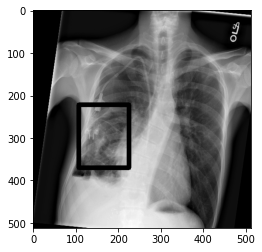

In [ ]:
for i in range(len(bbox0)):
    cv2.rectangle(img2[0], (int(bbox0[i][0]), int(bbox0[i][1])), (int(bbox0[i][2]), int(bbox0[i][3])), color=(0,0,0), thickness=10) 
plt.imshow(img2[0], cmap='gray')
plt.show()    